# 퍼널 분석

### 사전 분석 : hits
- 사용자 행동에 대한 상세 정보가 담긴 hits 컬럼값 분석

In [8]:
import os
import ast
import json
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from collections import defaultdict

color = sns.color_palette()
%matplotlib inline

In [8]:
train_path = '/Volumes/Expansion/google_analytics_customer/new_train.csv'
train_df = pd.read_csv(train_path)

/var/folders/l3/cq8y8n3s03v315zt58m2zrv80000gn/T/ipykernel_2618/2741465839.py:2: DtypeWarning:

Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.



In [9]:
train_df.head()

,channelGrouping,customDimensions,date,device,fullVisitorId,geoNetwork,hits,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Direct,"[{'index': '4', 'value': 'North America'}]",20160801,"{""browser"": ""Safari"", ""browserVersion"": ""not a...",6849420071276447389,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""33"", ""pageviews"": ""13...","{""campaign"": ""(not set)"", ""source"": ""(direct)""...",1470074045,1,1470074045
1,Referral,"[{'index': '4', 'value': 'North America'}]",20160801,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1231590494443171080,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '8', ...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""31"", ""pageviews"": ""23...","{""referralPath"": ""/"", ""campaign"": ""(not set)"",...",1470067091,2,1470067091
2,Direct,"[{'index': '4', 'value': 'North America'}]",20160801,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",6751290259214798595,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '6', ...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""31"", ""pageviews"": ""21...","{""campaign"": ""(not set)"", ""source"": ""(direct)""...",1470056945,1,1470056945
3,Referral,"[{'index': '4', 'value': 'North America'}]",20160801,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3213840074316400693,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '6', ...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""32"", ""pageviews"": ""24...","{""referralPath"": ""/"", ""campaign"": ""(not set)"",...",1470057237,2,1470057237
4,Referral,"[{'index': '4', 'value': 'North America'}]",20160801,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",2987126973357946088,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '21',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""32"", ""pageviews"": ""24...","{""referralPath"": ""/"", ""campaign"": ""(not set)"",...",1470112710,1,1470112710


## 사용자 행동 분석을 위한 컬럼 전처리

- json형태로 되어있는 device, geoNetwork, totals, trafficSource 컬럼 펼치기

In [11]:
def load_df(csv_path):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']

    df = pd.read_csv(csv_path,
                     converters={column: json.loads for column in JSON_COLUMNS},
                     dtype={'fullVisitorId': 'str'} # Important!!
                    )

    for column in JSON_COLUMNS:
        column_as_df = pd.json_normalize(df[column])  # ✅ 최신 방식 적용
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

sample_df = load_df('/Volumes/Expansion/google_analytics_customer/new_train.csv')
sample_df.head()

Loaded new_train.csv. Shape: (903653, 60)


,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,...,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.referralPath,trafficSource.keyword,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.campaignCode
0,Direct,"[{'index': '4', 'value': 'North America'}]",20160801,6849420071276447389,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1470074045,1,1470074045,Safari,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Referral,"[{'index': '4', 'value': 'North America'}]",20160801,1231590494443171080,"[{'hitNumber': '1', 'time': '0', 'hour': '8', ...",Not Socially Engaged,1470067091,2,1470067091,Chrome,...,not available in demo dataset,/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Direct,"[{'index': '4', 'value': 'North America'}]",20160801,6751290259214798595,"[{'hitNumber': '1', 'time': '0', 'hour': '6', ...",Not Socially Engaged,1470056945,1,1470056945,Chrome,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Referral,"[{'index': '4', 'value': 'North America'}]",20160801,3213840074316400693,"[{'hitNumber': '1', 'time': '0', 'hour': '6', ...",Not Socially Engaged,1470057237,2,1470057237,Chrome,...,not available in demo dataset,/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Referral,"[{'index': '4', 'value': 'North America'}]",20160801,2987126973357946088,"[{'hitNumber': '1', 'time': '0', 'hour': '21',...",Not Socially Engaged,1470112710,1,1470112710,Chrome,...,not available in demo dataset,/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### (1) 이탈률(bounce rate) 분석을 위한 주요 지표
- 이탈률 : 한 페이지 방문 후 다른 상호작용 없이 사이트를 떠난 방문자의 비율

**주요 Key**
- `page.pagePath` : 방문한 페이지의 경로
- `eCommerceAction.action_type` : 0이면 일반적인 페이지 조회, 1이면 제품 조회, 2 이상이면 특정 상호작용(구매, 장바구니 추가 등)을 의미
---
#### (2) 종료율 (exit rate) 분석을 위한 주요 지표
- 종료율 : 특정 페이지에서 세션이 종료된 비율
    - 즉, 방문자가 여러 페이지를 탐색한 후 마지막으로 본 페이지를 기준으로 계산

**주요 Key**
- `page.pagePath` : 방문한 페이지 경로
- `type` : `PAGE` 이므로 페이지뷰 이벤트인지 확인
---
#### (3) 퍼널 분석 (Funnel Analysis) 분석을 위한 주요 지표
- 퍼널 분석 : 사용자가 특정 목표(구매 완료)까지 진행하는 과정을 추적하는데 사용

**주요 Key**
- `eCommerceAction.action_type` : 사용자의 전자상거래 행동 (0 = 기본 조회, 1 = 제품조회, 2 = 장바구니 추가, 3 = 결제 진행, 4 = 구매 완료 등)
- `product` : 제품 상세정보 (사용자가 본 상품이 무엇인지)

#### ***hits 컬럼값 전처리**
- `'[{'key' : 'value'}]'`
- 문자열 안에 리스트 안에 딕셔너리 형태
- 데이터 규모가 너무 커 여러 개의 청크(chunk)로 나누어 코드 실행

- 추후 분석에 필요한 컬럼만 가져오기

In [12]:
sample_df = sample_df[['channelGrouping', 'date', 'fullVisitorId', 'hits', 'visitId', 'visitNumber', 
                       'visitStartTime', 'device.browser', 'device.operatingSystem', 'geoNetwork.continent', 
                       'geoNetwork.country', 'totals.visits', 'totals.hits', 'totals.pageviews', 'totals.newVisits', 
                       'totals.bounces', 'totals.transactions', 'totals.transactionRevenue', 'trafficSource.campaign', 
                       'trafficSource.source', 'trafficSource.medium']]

- chunk 분할 후 pickle 파일로 저장
    - csv로 저장 시 hits컬럼이 다시 string으로 저장됨

In [13]:
def process_and_save_batch(df, batch_index):
    print(f"Processing Batch '{batch_index}'...")

    # hits 컬럼에 ast.literal_eval() 적용
    df["hits"] = df["hits"].apply(ast.literal_eval)

    # Pickle 파일로 저장
    file_path = f"/Volumes/Expansion/google_analytics_customer/funnel_batch_df_{batch_index}.pkl"
    with open(file_path, "wb") as f:
        pickle.dump(df, f)

    print(f"Batch '{batch_index}' processed & saved at {file_path}")

In [14]:
# chunk 배치 사이즈 설정
batch_size = max(50000, len(sample_df) // os.cpu_count())

# 데이터 청크 나누기
num_batches = (len(sample_df) // batch_size) + 1    # 총 배치 개수 (총 9개)
df_chunks = np.array_split(sample_df, num_batches)  # 데이터프레임을 배치로 분할

print(f'Batch Num : ', {num_batches})
print(f'Batch 0 데이터프레임 행 : ', {len(df_chunks[0])})
print(f'Batch 1 데이터프레임 행 : ', {len(df_chunks[1])})
print(f'Batch 2 데이터프레임 행 : ', {len(df_chunks[2])})
print(f'Batch 3 데이터프레임 행 : ', {len(df_chunks[3])})
print(f'Batch 4 데이터프레임 행 : ', {len(df_chunks[4])})
print(f'Batch 5 데이터프레임 행 : ', {len(df_chunks[5])})
print(f'Batch 6 데이터프레임 행 : ', {len(df_chunks[6])})
print(f'Batch 7 데이터프레임 행 : ', {len(df_chunks[7])})
print(f'Batch 8 데이터프레임 행 : ', {len(df_chunks[8])})

/Users/taeheon/miniforge3/envs/customer/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning:

'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.



Batch Num :  {9}
Batch 0 데이터프레임 행 :  {100406}
Batch 1 데이터프레임 행 :  {100406}
Batch 2 데이터프레임 행 :  {100406}
Batch 3 데이터프레임 행 :  {100406}
Batch 4 데이터프레임 행 :  {100406}
Batch 5 데이터프레임 행 :  {100406}
Batch 6 데이터프레임 행 :  {100406}
Batch 7 데이터프레임 행 :  {100406}
Batch 8 데이터프레임 행 :  {100405}


In [15]:
# 청크 분할 후 작업 수행(pkl 파일 저장)
process_and_save_batch(df_chunks[8], batch_index=8)

Processing Batch '8'...
Batch '8' processed & saved at /Volumes/Expansion/google_analytics_customer/funnel_batch_df_8.pkl


## 1. 이탈률 및 종료율

### pkl 파일 load

In [3]:
pkl_paths = [f"/Volumes/Expansion/google_analytics_customer/funnel_batch_df_{i}.pkl" for i in range(9)]

# 각 Pickle 파일을 변수에 저장
batch_dfs = []
for i, path in enumerate(pkl_paths, start=1):
    with open(path, "rb") as f:
        batch_dfs.append(pickle.load(f))

# 변수명 자동 할당
batch_1_df, batch_2_df, batch_3_df, \
batch_4_df, batch_5_df, batch_6_df, \
batch_7_df, batch_8_df, batch_9_df = batch_dfs

### (1) 이탈률(bounce rate) 분석
- 이탈률 = 이탈수(totals.bounces) / 방문수(전체 행)
- **한 세션에서 사용자가 처음 방문한 페이지(`hitNumber == 1`)를 기준으로 그 사용자가 이탈(bounce)했는지를 판단하여 이탈한 페이지별 이탈률(bounce rate)을 계산**
- 쉽게 말해, 방문한 첫 페이지에서 얼마나 많은 사람이 아무것도 하지 않고 나갔는가?를 파악

In [30]:
def process_bounce_rate(df):
    # `hits` 컬럼에서 `hitNumber=1` & `type="PAGE"`인 경우 `pagePath` 추출
    def extract_page_path(hits_list):
        for hit in hits_list:  # 리스트 안의 모든 딕셔너리 반복
            if hit.get("hitNumber") == "1" and hit.get("type") == "PAGE":
                page = hit.get("page")  # "page" 키 존재 확인
                if "pagePath" in page:
                    return page["pagePath"]  # "pagePath" 값 반환
        return None  # 조건에 맞지 않으면 None 반환

    # `page_path` 컬럼 추가
    df["page_path"] = df["hits"].apply(extract_page_path)

    # `totals.bounces`를 float으로 변환
    df["totals.bounces"] = df["totals.bounces"].astype(float)

    # NaN 필터링
    df_filtered = df[df["page_path"].notna()][["page_path", "totals.bounces"]]

    # GROUP BY (페이지별 방문 수 & 이탈률 계산)
    bounce_result_df = df_filtered.groupby("page_path").agg(
        views=("page_path", "count"),               # 총 방문 횟수
        total_bounces=("totals.bounces", "sum")     # 총 이탈 횟수
    ).reset_index()

    return bounce_result_df

In [ ]:
bounce_1_df = process_bounce_rate(batch_1_df)
bounce_2_df = process_bounce_rate(batch_2_df)
bounce_3_df = process_bounce_rate(batch_3_df)
bounce_4_df = process_bounce_rate(batch_4_df)
bounce_5_df = process_bounce_rate(batch_5_df)
bounce_6_df = process_bounce_rate(batch_6_df)
bounce_7_df = process_bounce_rate(batch_7_df)
bounce_8_df = process_bounce_rate(batch_8_df)
bounce_9_df = process_bounce_rate(batch_9_df)

In [32]:
# 모든 batch 데이터프레임을 리스트에 저장
bounce_dfs = [
    bounce_1_df, bounce_2_df, bounce_3_df, bounce_4_df, bounce_5_df,
    bounce_6_df, bounce_7_df, bounce_8_df, bounce_9_df
]

# 모든 배치 데이터를 하나의 데이터프레임으로 병합
combined_df = pd.concat(bounce_dfs, ignore_index=True)

# page_path별 그룹화하여 views와 total_bounces 합산
bounce_df = combined_df.groupby('page_path').agg(
    views=('views', 'sum'),
    total_bounces=('total_bounces', 'sum')
).reset_index()

# 이탈률 계산
bounce_df["bounce_rate"] = bounce_df["total_bounces"] / bounce_df["views"]

# page_path label 지정 (URL 마지막 부분)
bounce_df['label'] = bounce_df['page_path'].apply(lambda x : x.split('/')[-1])

# views 기준 정렬 및 상위 10개 행 추출
bounce_df = bounce_df.sort_values('views', ascending=False).head(10)

In [33]:
bounce_df

,page_path,views,total_bounces,bounce_rate,label
1180,/home,612060,303260.0,0.495474,home
1157,/google+redesign/shop+by+brand/youtube,81492,45827.0,0.562350,youtube
265,/google+redesign/apparel/men++s/men++s+t+shirts,20684,9125.0,0.441162,men++s+t+shirts
1216,/signin.html,16296,5893.0,0.361622,signin.html
514,/google+redesign/apparel/mens/mens+t+shirts,12691,6029.0,0.475061,mens+t+shirts
3,/basket.html,9431,4287.0,0.454565,basket.html
764,/google+redesign/drinkware,8831,4714.0,0.533801,drinkware
644,/google+redesign/bags,8608,3884.0,0.451208,bags
261,/google+redesign/apparel/men++s/men++s+outerwear,6344,2746.0,0.432850,men++s+outerwear
142,/google+redesign/apparel,6325,2835.0,0.448221,apparel


/var/folders/l3/cq8y8n3s03v315zt58m2zrv80000gn/T/ipykernel_87351/3313470727.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bounce_result_df['label'], y=bounce_result_df['bounce_rate'], palette='Reds_r')


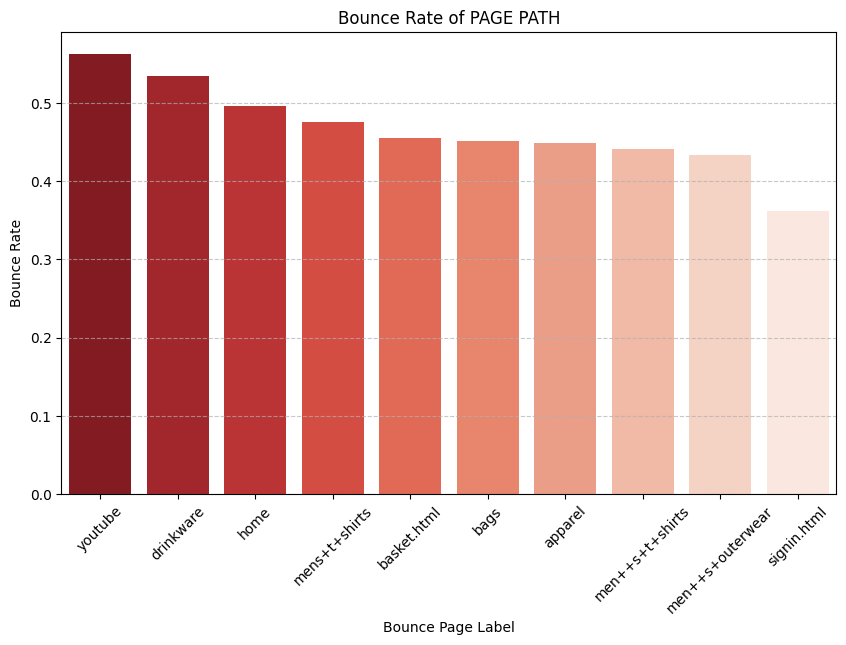

In [34]:
# 시각화
bounce_result_df = bounce_df.sort_values("bounce_rate", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=bounce_result_df['label'], y=bounce_result_df['bounce_rate'], palette='Reds_r')
plt.xlabel("Bounce Page Label")
plt.ylabel("Bounce Rate")
plt.title("Bounce Rate of PAGE PATH")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 이탈률 분석 시사점

1. **`/home` : 이탈률 49.5%** 
    - 전체 61만 건 중 절반이 `/home` 에서 이탈
    - 전체 세션이 약 90만인 걸 감안했을 때, `/home` 에서의 이탈률이 50%에 가깝다는 것은 **전체 사용자 중 약 70%(90만 : 60만)의 사용자들이 `/home` 를 랜딩 페이지로서 접근을 하고, 그 중 절반 가까이는 아무것도 하지 않고 해당 페이지를 떠났다는 것.**
    - 시사점
        - 홈에서 다른 카테고리나 프로모션으로의 유입 흐름이 약할 수 있음
        - CTA(Call To Action), 배너 위치, 다른 페이지 전환을 위한 이목을 끌 수 있는 콘텐츠 재점검 등이 필요해보임.
2. **`/youtube` : 이탈률 56.2%**
    - 이탈률이 사용자의 절반을 넘음
    - **특정 브랜드(youtube) 페이지가 기대한 정보 전달을 못 하고 있을 가능성이 있음**
    - 시사점
        - 방문자가 원하는 콘텐츠, 상품, 브랜드 정보가 초기에 명학히 노출되고 있지 않음
        - 추천 상품, 사용자 리뷰 등 신뢰 기반 콘텐츠 필요해보임
3. **카테고리별 페이지(`/men++s+t+shirts`, `/mens+t+shirts`, `/bags`, `/drinkware`, `/outwearm`, `/apparel` 등) : 평균 이탈률 43~45%**
    - 시사점
        - 상품 카테고리 페이지는 흥미 유도는 어느 정도 있지만, 상품 클릭 전 이탈도 많음
        - 첫 화면에 노출되는 상품 배치 전략, 필터 기능 UX 개선, 로딩 속도 점검 등이 필요해보임
4. **`/signin.html` : 이탈률 36.1%**
    - 이탈률 낮음
    - 시사점
        - 로그인까지 온 사용자는 목적이 명확함 (재방문자, 구매 목적 등)
        - 전환에 가까운 사용자가 머무르는 구간이기에 이탈률이 낮은 것은 정상
        - 단, 로그인 이후 전환이 이어지는지 분석 필요
5. **`/basket.html` : 이탈률 45.4%**
    - 장바구니 페이지 이탈률이 꽤 높음
    - 시사점 :
        - 구매로 이어지지 않고 장바구니에서 나가는 사용자 많음
        - 원인 예측 : 예상보다 높은 배송비, 결제단계 UX 혼잡, 로그인 유도 타이밍 불편 등
    - 해결 방안 :
        - 배송비 노출 명확화, 장바구니 UX 개선, 구매 유도 팝업 및 할인 배너 추가 등

### (2) 종료율(exit rate) 분석
- 종료율 = 종료수(total.bounces) / 방문수(views)
- 이탈률과 다르게 종료율은 사용자가 여러 페이지를 이동하다가 마지막으로 세션을 종료시킨 페이지를 통해 분석한다.
- hits의 상호작용 데이터들(딕셔너리) 중 마지막 PAGE 타입의 pagePath로 집계
    - hits = [{hit1}, {hit2}, {hit3}]과 같이 여러 개의 상호작용(hit1, 2, 3)이 있을 때 `type == “PAGE”`인 hit 중 가장 마지막 딕셔너리가 사용자가 보고 세션을 종료한 상호작용

In [14]:
def process_exit_rate(df):
    # 딕셔너리 초기화
    page_views = defaultdict(int)
    page_exits = defaultdict(int)

    # 세션 단위로 순회
    for hits_list in df["hits"]:
        if not isinstance(hits_list, list):
            continue

        exit_page = None  # 종료 페이지
        pages_seen = set()  # 세션 내 중복 방지

        for hit in hits_list:
            if hit.get("type") == "PAGE":
                page = hit.get("page")
                if isinstance(page, dict) and "pagePath" in page:
                    page_path = page["pagePath"]
                    exit_page = page_path  # 마지막 PAGE 덮어쓰기

                    # 조회 수 누적 (중복 허용)
                    page_views[page_path] += 1

        # 종료 페이지 수 누적
        if exit_page:
            page_exits[exit_page] += 1

    # 결과 DataFrame 생성
    result_df = pd.DataFrame({
        "page_path": list(page_views.keys()),
        "views": list(page_views.values()),
        "exits": [page_exits[path] for path in page_views.keys()]
    })

    return result_df

In [10]:
exit_1_df = process_exit_rate(batch_1_df)
exit_2_df = process_exit_rate(batch_2_df)
exit_3_df = process_exit_rate(batch_3_df)
exit_4_df = process_exit_rate(batch_4_df)
exit_5_df = process_exit_rate(batch_5_df)
exit_6_df = process_exit_rate(batch_6_df)
exit_7_df = process_exit_rate(batch_7_df)
exit_8_df = process_exit_rate(batch_8_df)
exit_9_df = process_exit_rate(batch_9_df)

In [12]:
# 모든 batch 결과 저장
exit_dfs = [
    exit_1_df, exit_2_df, exit_3_df, exit_4_df, exit_5_df,
    exit_6_df, exit_7_df, exit_8_df, exit_9_df
]

# 배치 데이터 병합
combined_df = pd.concat(exit_dfs, ignore_index=True)

# page_path 기준 집계 (컬럼명 정리: exits → total_exits)
exit_df = combined_df.groupby("page_path").agg(
    views=("views", "sum"),
    total_exits=("exits", "sum")
).reset_index()

# 종료율 계산
exit_df["exit_rate"] = exit_df["total_exits"] / exit_df["views"]

# 마지막 URL segment를 라벨로 지정
exit_df["label"] = exit_df["page_path"].apply(lambda x: x.split("/")[-1])

# 정렬 및 상위 10개 추출
exit_df = exit_df.sort_values("views", ascending=False).head(10)

exit_df

,page_path,views,total_exits,exit_rate,label
2360,/home,981153,420765,0.428847,home
3,/basket.html,209355,23138,0.110520,basket.html
2317,/google+redesign/shop+by+brand/youtube,145000,69096,0.476524,youtube
2422,/signin.html,101295,25482,0.251562,signin.html
2555,/store.html,93551,12222,0.130645,store.html
503,/google+redesign/apparel/men++s/men++s+t+shirts,67465,17957,0.266168,men++s+t+shirts
0,/asearch.html,62379,19894,0.318921,asearch.html
1683,/google+redesign/electronics,56835,12008,0.211278,electronics
236,/google+redesign/apparel,56537,10892,0.192653,apparel
1391,/google+redesign/bags,53684,9785,0.182270,bags


/var/folders/l3/cq8y8n3s03v315zt58m2zrv80000gn/T/ipykernel_6744/2994184424.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=exit_result_df['label'], y=exit_result_df['exit_rate'], palette='Blues_r')


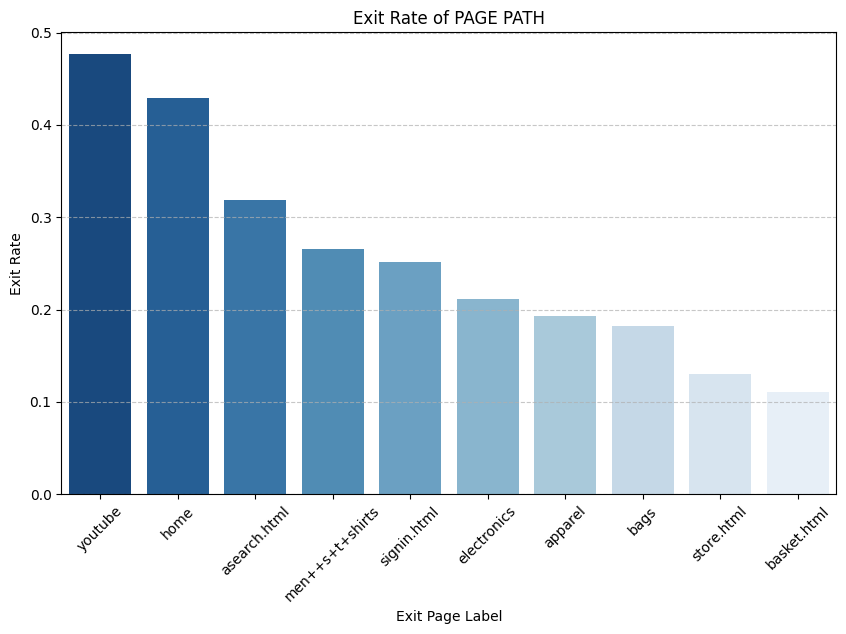

In [13]:
# 시각화
exit_result_df = exit_df.sort_values("exit_rate", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=exit_result_df['label'], y=exit_result_df['exit_rate'], palette='Blues_r')
plt.xlabel("Exit Page Label")
plt.ylabel("Exit Rate")
plt.title("Exit Rate of PAGE PATH")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 종료율 분석 시사점

1. **`/home` : 종료율 42.9%**
    - 사이트의 중심이지만 종료수(total_exits)가 가장 많음
    - 시사점
        - 방문자가 홈에서 더 이상 흥미로운 콘텐츠를 발견하지 못했을 가능성
        - 혹은 홈을 북마크 등으로 직접 방문 후 종료하는 사용자도 존재할 수 있음
        - CTA 개선, 상품 및 카테고리 유도 배너 재배치 필ㄹ요
2. **`/basket.html` : 종료율 11.1%**
    - 사용자가 장바구니에서 이탈하지 않고 다음 단계(결제 등)로 이동했음을 시사
    - 시사점 :
        - 전환 흐름이 잘 설계되어 있음
        - 다만, 최종 결제 완료까지 이어졌는지는 추가 분석 필요
        - 이탈률이 45.4%였던 것과 차이가 있음 → 두 지표 조합해서 해석 필요
3. **`/youtube` : 종료율 47.6%**
    - 가장 높은 이탈률과 종료율을 보임
    - 시사점 :
        - 콘텐츠의 흡입력 부족, 상품 상세 페이지로의 유도 부족
4. **`/signin.html` : 종료율 25.2%**
    - 로그인 페이지에서 4명 중 1명은 로그인 후 떠남
    - 시사점 :
        - 로그인 이후 구매, 탐색으로 연결되지 않는 사용자가 존재
        - UX 흐름 점검 : 로그인 후 리다이렉트 위치, UX 불편 여부 등
5. **`/store.html` : 종료율 13.0%**
    - 전체 상품 리스트로 추정
    - 시사점 :
        - 세션이 종료되지 않고 탐색이 활발히 일어나는 구간임을 알 수 있음
6. **`/asearch.html` : 종료율 31.9%**
    - 검색 후 떠나는 사용자 비율
    - 시사점 :
        - 검색 결과 품질 부족 가능성
        - 사용자 행동 분석 필요 : 검색 키워드 분석 + 상품 클릭 유무 확인
7. **카테고리별 페이지(`/electronics`, `/apparel`, `/bags`) : 종료율 18~21%**
    - 상품 카테고리 페이지로 종료율 낮은 편
    - 시사점 :
        - 탐색형 페이지로 기능을 잘 수행 중
        - 특정 상품 클릭, 비교 등 사용자 행동이 이루어지는 흐름 파악

## 2. 브라우저 및 기기별 분석
- 세션별 접속한 브라우저와 기기 정보에 따른 종료율 분석
- 브라우저 및 기기의 호환성 문제 파악

### (1) 브라우저별 종료율 분석
- 주요 지표 : `device.browser` (사용된 브라우저)

In [129]:
browser_exit_df = sample_df.copy()

browser_exit_df['totals.bounces'] = browser_exit_df['totals.bounces'].astype(float)

# device.browser가 있는 행만 필터링
df_filtered = browser_exit_df[['device.browser', 'totals.bounces']]

browser_result_df = df_filtered.groupby("device.browser").agg(
    views=("device.browser", "count"),          # 총 방문 횟수
    browser_exits=("totals.bounces", "sum")       # 총 종료 횟수
).reset_index()

# 종료율
browser_result_df['exit_rate'] = browser_result_df['browser_exits'] / browser_result_df['views']

# 정렬 및 상위 10개 출력
browser_result_df = browser_result_df.sort_values('views', ascending=False).head(10)

browser_result_df

,device.browser,views,browser_exits,exit_rate
11,Chrome,620364,291266.0,0.469508
40,Safari,182245,98385.0,0.539850
16,Firefox,37069,22343.0,0.602741
20,Internet Explorer,19375,11773.0,0.607639
15,Edge,10205,5694.0,0.557962
6,Android Webview,7865,4487.0,0.570502
41,Safari (in-app),6850,4029.0,0.588175
37,Opera Mini,6139,4017.0,0.654341
36,Opera,5643,3217.0,0.570087
46,UC Browser,2427,1636.0,0.674083


/var/folders/l3/cq8y8n3s03v315zt58m2zrv80000gn/T/ipykernel_35823/3283321435.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




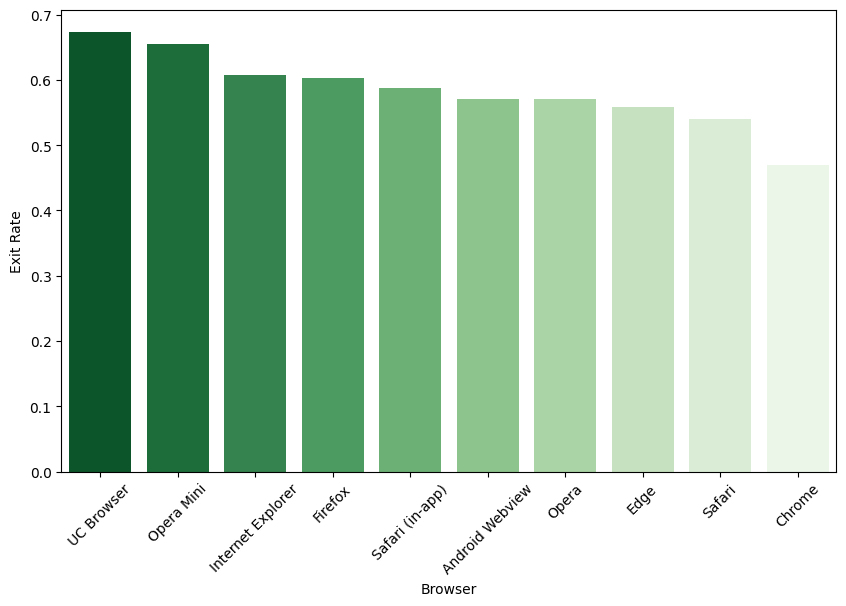

In [119]:
# 시각화
browser_result_df = browser_result_df.sort_values("exit_rate", ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=browser_result_df['device.browser'], y=browser_result_df['exit_rate'], palette='Greens_r')
plt.xlabel("Browser")
plt.ylabel("Exit Rate")
plt.xticks(rotation=45)
plt.show()

Chrome 사용자의 방문 수(views)가 압도적으로 많지만 종료율은 상위 10개 브라우저 중에서 가장 낮다.

반면 Internet Explorer, Firefox 사용자의 방문수는 각각 4, 5위에 높은 축에 속하면서 종료율 또한 3, 4위로 상당히 높은 순위에 속해있는 것을 알 수 있다. 즉, 해당 브라우저 사용자가 많으면서 동시에 종료율도 높은 것.

UC Browser, Opera Mini는 사용자의 방문 수는 상위 10개 브라우저 중에서 굉장히 낮은 값이기에 표본이 적어 높은 종료율 순위에 자리매김한 듯하다.

### (2) 기기별 종료율 분석

- 주요 지표 : `device.deviceCategory` (사용된 기기)

In [122]:
# 기기 사용자 통계
sample_df['device.deviceCategory'].value_counts()

device.deviceCategory
desktop    664479
mobile     208725
tablet      30449
Name: count, dtype: int64

In [132]:
device_exit_df = sample_df.copy()

device_exit_df['totals.bounces'] = device_exit_df['totals.bounces'].astype(float)

# device.deviceCategory 있는 행만 필터링
df_filtered = device_exit_df[['device.deviceCategory', 'totals.bounces']]

# device.deviceCategory별 그룹화
device_result_df = df_filtered.groupby("device.deviceCategory").agg(
    views=("device.deviceCategory", "count"),    # 총 방문 횟수
    device_exits=("totals.bounces", "sum")       # 총 종료 횟수
).reset_index()

# 종료율
device_result_df['exit_rate'] = device_result_df['device_exits'] / device_result_df['views']

# 정렬 및 상위 10개 출력
device_result_df = device_result_df.sort_values('views', ascending=False).head(10)

device_result_df

,device.deviceCategory,views,device_exits,exit_rate
0,desktop,664479,327072.0,0.492223
1,mobile,208725,108450.0,0.519583
2,tablet,30449,15108.0,0.496174


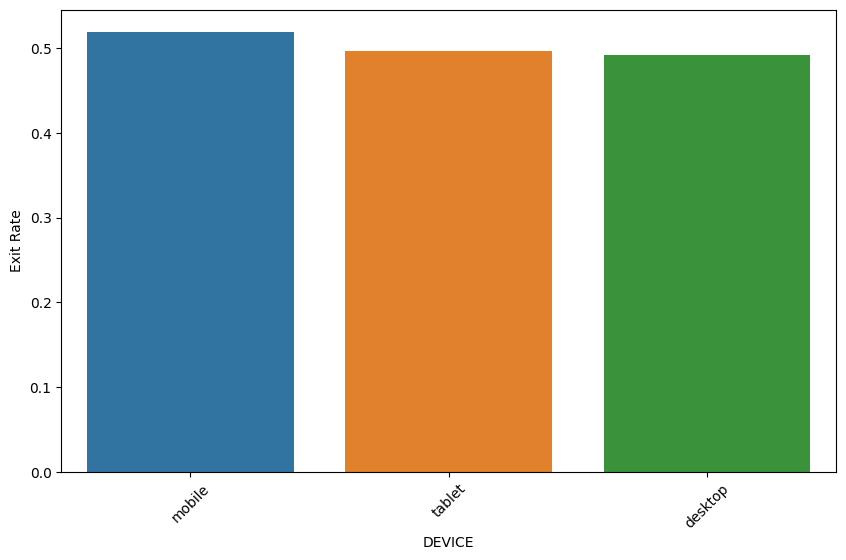

In [137]:
# 시각화
device_result_df = device_result_df.sort_values("exit_rate", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=device_result_df['device.deviceCategory'], y=device_result_df['exit_rate'], hue=device_result_df['device.deviceCategory'])
plt.xlabel("DEVICE")
plt.ylabel("Exit Rate")
plt.xticks(rotation=45)
plt.show()

모바일 기기의 종료율이 데스크탑, 테블릿보다 높다.

앞선 EDA에서 모바일은 전체 세션의 20%정도를 차지하고 있지만 결제는 데스크탑이 압도적인 차이로 높은 비율을 차지하고 있었기 때문에 모바일로 상품을 확인하고 실제 결제는 desktop에서 이뤄졌을수도 있다.

모바일 및 테블릿 환경에서의 store 접근 환경이 최적화되어 있는지 확인하고 개선할 필요가 있다.

### (3) OS별 종료율 분석
- 주요 지표 : `device.operatingSystem` (사용된 OS)

In [135]:
# OS 사용자 통계
sample_df['device.operatingSystem'].value_counts().head(10)

device.operatingSystem
Windows          350072
Macintosh        253938
Android          123892
iOS              107665
Linux             35034
Chrome OS         26337
(not set)          4695
Windows Phone      1216
Samsung             280
BlackBerry          218
Name: count, dtype: int64

In [136]:
os_exit_df = sample_df.copy()

os_exit_df['totals.bounces'] = os_exit_df['totals.bounces'].astype(float)

# device.deviceCategory 있는 행만 필터링
df_filtered = os_exit_df[['device.operatingSystem', 'totals.bounces']]

# device.deviceCategory별 그룹화
os_result_df = df_filtered.groupby("device.operatingSystem").agg(
    views=("device.operatingSystem", "count"),    # 총 방문 횟수
    os_exits=("totals.bounces", "sum")       # 총 종료 횟수
).reset_index()

# 종료율
os_result_df['exit_rate'] = os_result_df['os_exits'] / os_result_df['views']

# 정렬 및 상위 10개 출력
os_result_df = os_result_df.sort_values('views', ascending=False).head(10)

os_result_df

,device.operatingSystem,views,os_exits,exit_rate
16,Windows,350072,195873.0,0.559522
7,Macintosh,253938,108059.0,0.425533
1,Android,123892,65498.0,0.528670
19,iOS,107665,53407.0,0.496048
6,Linux,35034,13835.0,0.394902
3,Chrome OS,26337,9672.0,0.367240
0,(not set),4695,2994.0,0.637700
17,Windows Phone,1216,733.0,0.602796
14,Samsung,280,194.0,0.692857
2,BlackBerry,218,158.0,0.724771


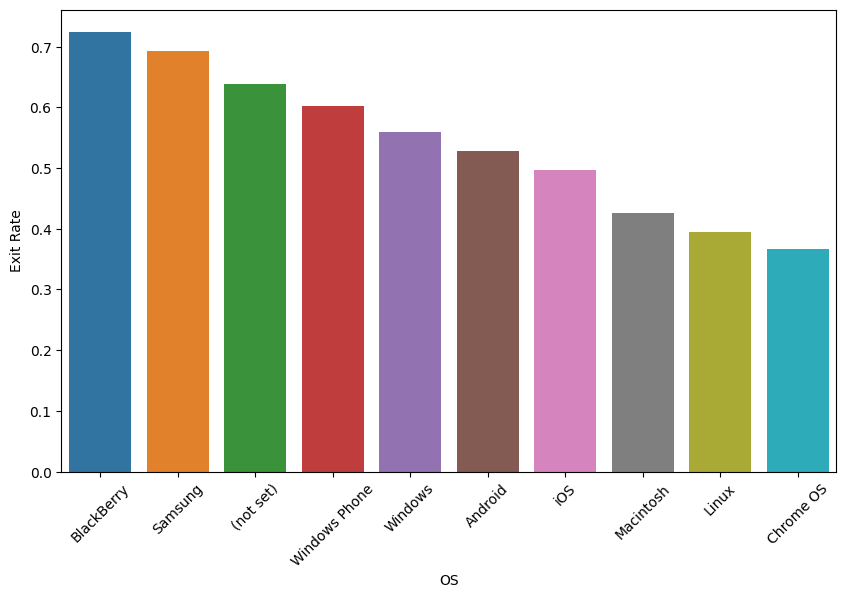

In [140]:
# 시각화
os_result_df = os_result_df.sort_values("exit_rate", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=os_result_df['device.operatingSystem'], y=os_result_df['exit_rate'], hue=os_result_df['device.operatingSystem'])
plt.xlabel("OS")
plt.ylabel("Exit Rate")
plt.xticks(rotation=45)
plt.show()

## 3. 퍼널 분석
- 전환 과정 중 사용자 행동을 통해 이탈 단계 분석

- 주요 지표 : `hits.eCommerceAction.action_type`
    - 0 : 알수없음
    - 1 : 제품 목록 (Click through of product lists')
    - 2 : 제품 상세보기 (Product detail views)
    - 3 : 장바구니에 제품 추가 (Add to cart)
    - 4 : 장바구니에서 제품 삭제 (Remove from cart)
    - 5 : 결제 (Check out)
    - 6 : 구매 완료 (Completed Purchase)
    - 7 : 구매 환불
    - 8 : 결제 옵션

In [16]:
def extract_action_type(df):
    # `hits` 컬럼에서 `eCommerceAction.action_type`을 추출하여 매핑
    def extract_actions(hits_list):
        if not isinstance(hits_list, list):  # 리스트인지 확인
            return None
        
        actions = []  # 모든 action_type 저장
        for hit in hits_list:  # `hits` 리스트 안의 모든 딕셔너리 반복
            if isinstance(hit, dict):
                ecom_action = hit.get("eCommerceAction")  # `eCommerceAction` 키 확인
                if isinstance(ecom_action, dict):  # `eCommerceAction` 값이 딕셔너리인지 확인
                    action_type = str(ecom_action.get("action_type"))  # 문자열 변환
                    action_mapping = {
                        "1": "Click through of product lists",
                        "2": "Product detail views",
                        "5": "Check out",
                        "6": "Completed purchase"
                    }
                    mapped_action = action_mapping.get(action_type, None)
                    if mapped_action:
                        actions.append(mapped_action)  # 모든 action_type 추가
        
        return actions  # 중복 제거 없이 모든 action_type 반환

    # `action` 컬럼 추가 (리스트 형태로 저장)
    df["action"] = df["hits"].apply(extract_actions)

    # `action`이 빈 리스트가 아닌 경우만 필터링
    df_filtered = df[df["action"].apply(lambda x: len(x) > 0)][["action", "fullVisitorId"]]

    # `action` 컬럼을 리스트에서 개별 행으로 변환 (explode 대체)
    df_filtered = df_filtered.explode("action")

    # GROUP BY (action_type 별 총 수행 횟수 계산)
    grouped_df = df_filtered.groupby("action").agg(
        total_hits=("fullVisitorId", "count")  # 방문 횟수(세션 기준) 합산
    ).reset_index()

    return grouped_df

In [17]:
funnel_1_df = extract_action_type(batch_1_df)
funnel_2_df = extract_action_type(batch_2_df)
funnel_3_df = extract_action_type(batch_3_df)
funnel_4_df = extract_action_type(batch_4_df)
funnel_5_df = extract_action_type(batch_5_df)
funnel_6_df = extract_action_type(batch_6_df)
funnel_7_df = extract_action_type(batch_7_df)
funnel_8_df = extract_action_type(batch_8_df)
funnel_9_df = extract_action_type(batch_9_df)

In [18]:
# 모든 개별 데이터프레임을 리스트로 저장
funnel_dfs = [
    funnel_1_df, funnel_2_df, funnel_3_df, funnel_4_df, funnel_5_df,
    funnel_6_df, funnel_7_df, funnel_8_df, funnel_9_df
]

# 모든 배치 데이터를 하나의 데이터프레임으로 병합
combined_df = pd.concat(funnel_dfs, ignore_index=True)

# action별로 그룹화하여 total_hits(user 기준) 합산
final_df = combined_df.groupby("action").agg(
    users=("total_hits", "sum")
).reset_index()

# 세션 수 기준 정렬
final_df = final_df.sort_values("users", ascending=False)

final_df

,action,users
1,Click through of product lists,445745
3,Product detail views,362593
0,Check out,88019
2,Completed purchase,24532


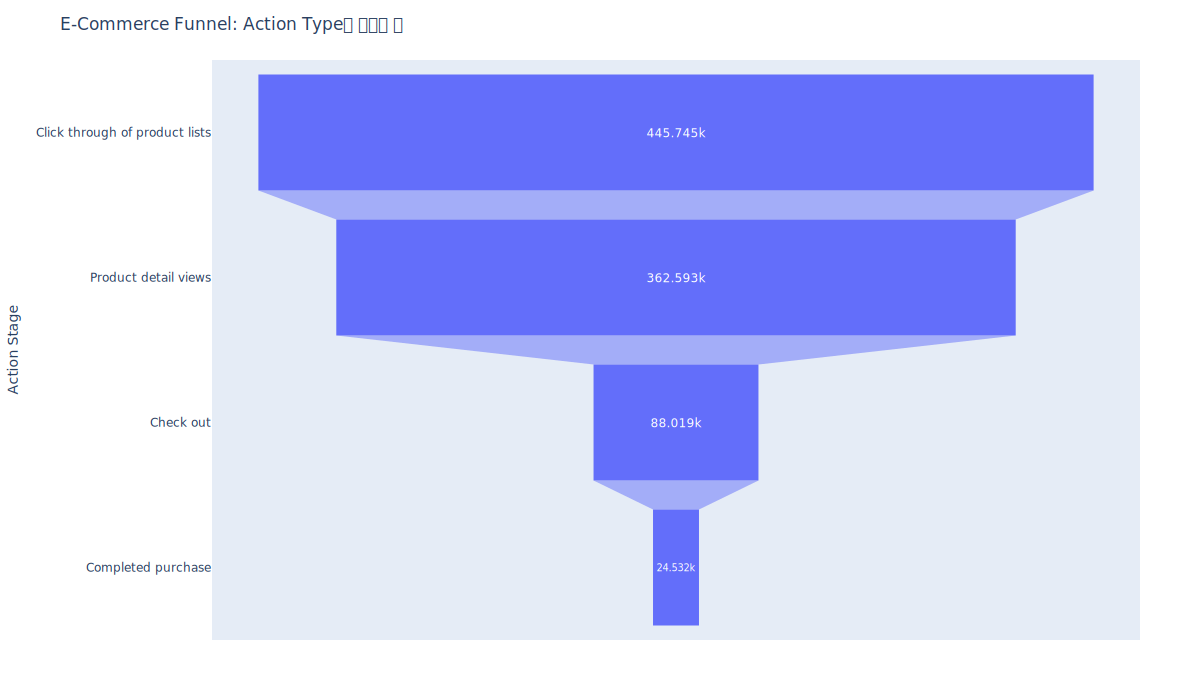

In [21]:
# 퍼널 시각화

# 퍼센트 계산 (최상단 단계 대비)
final_df = final_df.sort_values("users", ascending=False).reset_index(drop=True)
max_users = final_df["users"].iloc[0]
final_df["percent"] = final_df["users"] / max_users * 100

# 퍼센트 포함된 라벨 생성
final_df["label"] = final_df.apply(lambda row: f"{row['action']} ({row['users']:,} users, {row['percent']:.1f}%)", axis=1)

# final_df에는 'action', 'users' 컬럼이 있다고 가정
fig = px.funnel(
    data_frame=final_df,
    x="users",
    y="action",
    title="E-Commerce Funnel: Action Type별 사용자 수"
)

# 옵션: 글자 크기 조정, 색상 등 커스터마이징 가능
fig.update_layout(
    width=1200,          # 그래프 가로 사이즈
    height=700,          # 그래프 세로 사이즈
    font=dict(size=12),  # 전체 폰트 사이즈 축소
    margin=dict(t=60, l=100, r=60, b=60),
    yaxis_title="Action Stage",
    xaxis_title="Number of Users",
)

fig.show("svg")